# Supernova Signals

State of the art Supernova Simulations show that the full supernova signal is hard to predict. Many processes contribute to the final signal, and small changes in the initial conditions can lead to large differences in the outcome.

While there are some parts of the signal that are understood, there doesn't exist a single waveform / approximant. As such GWFish which was built for compact binary coalescences does not have supernova waveforms.

Here we show how to add supernova signals to GWFish using custom waveforms. And how to extract SNR / horizon distances for these signals.

In [1]:
%load_ext autoreload
%autoreload 2

import ludolib  as ll # contains helper functions
import GWFish   as gw

# Some standard imports
import  numpy               as np
import  matplotlib.pyplot   as plt
from    pathlib             import Path

# astropy
from    astropy import units      as u

#make default fontsize 14 
plt.rcParams.update({'font.size': 14})

/home/ludo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ludo/.local/lib/python3.10/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir

## Signal Preparation 

We are going to take waveforms from 3D supernova simulations performed by Vartanyan et al. (2023) and Radice et al. (2019). These waveforms are available [here](https://www.astro.princeton.edu/~burrows/).

The files are in the format:

```
time (s) | h_plus | h_cross
```

To obtain the strain at a given distance D, we need to rescale by a factor of 1/D.

In [2]:
# Load waveforms
t_9, hp_9, hc_9     = np.loadtxt(Path("waveforms") / "9.25_gwstrain_trim.dat", unpack=True)
t_15, hp_15, hc_15  = np.loadtxt(Path("waveforms") / "s15.0.swbj16.horo.3d.gw.dat", unpack=True)

We also have to resample the waveforms to a uniform time grid, and normalize them for a source at 10 kpc.

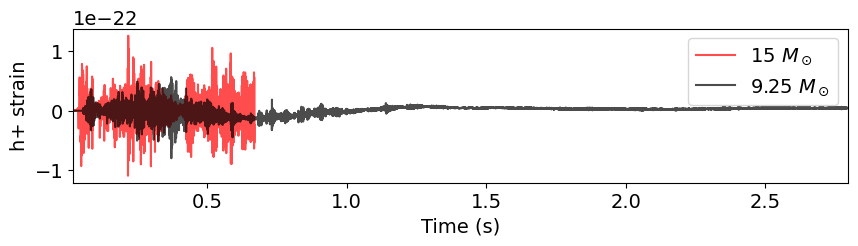

In [3]:

# resample to common time array
dt = 0.05 / 1000 # ms
t_common_9 = np.arange(t_9[0], t_9[-1], dt)
t_common_15 = np.arange(t_15[0], t_15[-1], dt)
hp_9    = np.interp(t_common_9, t_9, hp_9)
hc_9    = np.interp(t_common_9, t_9, hc_9)
hp_15   = np.interp(t_common_15, t_15, hp_15)
hc_15   = np.interp(t_common_15, t_15, hc_15)
t_9     = t_common_9
t_15    = t_common_15

distance = (10 * u.kpc).to(u.cm)
# Rescale waveforms to given distance
hp_9   /= distance.value
hc_9   /= distance.value
hp_15  /= distance.value
hc_15  /= distance.value

# Plot waveforms
plt.figure(figsize=(10, 2))
plt.plot(t_15, hp_15, label="15 $M_\odot$", color='r', alpha=0.7)
plt.plot(t_9, hp_9, label="9.25 $M_\odot$", color='k', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("h+ strain")
plt.legend()
plt.xlim(min(t_9), max(t_9))
plt.show()

We can also quickly look at the FFT of the signals to see their frequency content

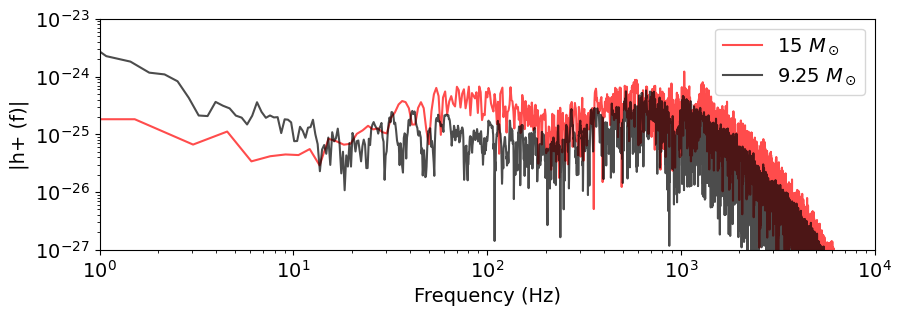

In [4]:
# make_fft(time_array, time_series)
freqs_9, hp_f_9     = ll.make_fft(t_9, hp_9)
freqs_9, hc_f_9     = ll.make_fft(t_9, hc_9)
freqs_15, hp_f_15   = ll.make_fft(t_15, hp_15)
freqs_15, hc_f_15   = ll.make_fft(t_15, hc_15)

# Plot FFTs
plt.figure(figsize=(10, 3))
plt.loglog(freqs_15, np.abs(hp_f_15), label="15 $M_\odot$", color='r', alpha=0.7)
plt.loglog(freqs_9, np.abs(hp_f_9), label="9.25 $M_\odot$", color='k', alpha=0.7)

plt.xlabel("Frequency (Hz)")
plt.ylabel("|h+ (f)|")
plt.legend()
plt.xlim(1, 1e4)
plt.ylim(1e-27, 1e-23)  
plt.show()

As you already know the signal we see within the detector will be some linear combination of the two polarizations, depending on the sky location and polarization angle of the source.

Let us select a detector, for now Einstein Telescope. And see the projected signal on the detector for a given sky location and polarization angle. 

To understand what each parameter refers to, please refer to the [GWFish documentation](https://gwfish.readthedocs.io/en/latest/).

Here we quickly create a configuration for ET. This already exists by default in GWFish, but we show how to create it from scratch for demonstration purposes.

In [5]:
# Create detector.yaml
content = """ET:
    lat:              (40 + 31. / 60 ) * np.pi / 180.
    lon:              (9 + 25. / 60) * np.pi / 180.
    opening_angle:    np.pi / 3.
    azimuth:          70.5674 * np.pi / 180.
    psd_data:         ET_psd.txt
    duty_factor:      0.85
    detector_class:   earthDelta
    plotrange:        3, 1000, 1e-25, 1e-20
    fmin:             2.
    fmax:             10000.
    spacing:          geometric
    df:               1./16.
    npoints:          1000
    arm_length:       10000  
"""

Path("detector.yaml").write_text(content)

config = "detector.yaml"

For now we take a simple set of parameters.

In [6]:
params_tutorial = {
    'ra'            : 0.0,
    'dec'           : 0.0,
    'psi'           : 0.0,
    'geocent_time'  : 1395964818
}

In [7]:
detectors = ["ET"]

# We need to correct the phase of the strains to match the convention used in GWFish

hp_f_15, hc_f_15 = ll._fd_phase_correction_and_output_format_from_stain_series(
    f_          = freqs_15,
    hp          = hp_f_15,
    hc          = hc_f_15,
    geo_time    = params_tutorial['geocent_time'],
).T

hp_f_9, hc_f_9 = ll._fd_phase_correction_and_output_format_from_stain_series(
    f_          = freqs_9,
    hp          = hp_f_9,
    hc          = hc_f_9,
    geo_time    = params_tutorial['geocent_time'],
).T

projections_15  = ll.calculate_detector_projections(
    detector_ids    =   detectors,
    hp_f            =   hp_f_15,
    hc_f            =   hc_f_15,
    freqs           =   freqs_15,
    sky_params      =   params_tutorial,
    config          =   config,
)

projections_9   = ll.calculate_detector_projections(
    detector_ids    =   detectors,
    hp_f            =   hp_f_9,
    hc_f            =   hc_f_9,
    freqs           =   freqs_9,
    sky_params      =   params_tutorial,
    config          =   config,
)

/home/ludo/.local/lib/python3.10/site-packages/GWFish/modules/detection.py:457: RuntimeWarning: invalid value encountered in divide
  return np.sin(x)/x
/home/ludo/.local/lib/python3.10/site-packages/GWFish/modules/detection.py:457: RuntimeWarning: invalid value encountered in divide
  return np.sin(x)/x
/home/ludo/.local/lib/python3.10/site-packages/GWFish/modules/detection.py:457: RuntimeWarning: invalid value encountered in divide
  return np.sin(x)/x
/home/ludo/.local/lib/python3.10/site-packages/GWFish/modules/detection.py:457: RuntimeWarning: invalid value encountered in divide
  return np.sin(x)/x
/home/ludo/.local/lib/python3.10/site-packages/GWFish/modules/detection.py:457: RuntimeWarning: invalid value encountered in divide
  return np.sin(x)/x
/home/ludo/.local/lib/python3.10/site-packages/GWFish/modules/detection.py:457: RuntimeWarning: invalid value encountered in divide
  return np.sin(x)/x


ET has 3 components (delta) we can look at one specific component. Given the definition of the SNR, we plot the characteristic strain 
$$
h_c(f) = 2 f |h(f)|
$$
And for the detector sensitivity we plot
$$
S_c(f) = \sqrt{f}\sqrt{PSD}
$$

Given that the SNR is simply given by 
$$

\mathrm{SNR}^2 = \int \frac{h_c^2(f)}{S_c^2(f)} \frac{df}{f}

$$

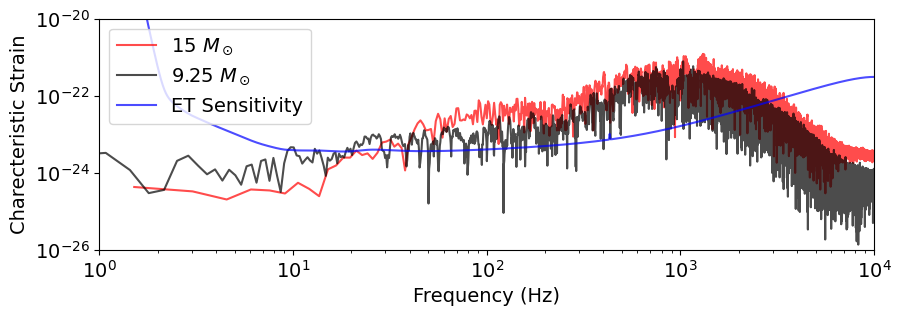

In [8]:
proj_0_15, names    = projections_15
proj_0_9, _         = projections_9

h_c_0_15 = 2 * freqs_15* np.abs(proj_0_15.T[0])
h_c_0_9  = 2 * freqs_9 * np.abs(proj_0_9.T[0])

plt.figure(figsize=(10, 3))
# The factor 2 reflects the definition of the SNR
plt.loglog(freqs_15 , h_c_0_15, label="15 $M_\odot$", color='r', alpha=0.7)
plt.loglog(freqs_9  , h_c_0_9, label="9.25 $M_\odot$", color='k', alpha=0.7)

detector            = gw.detection.Detector("ET", config="detector.yaml")
f_ref               = np.logspace(0, 4, 1000)
component           = detector.components[0]  # delta component
noise_psd_ref       = component.Sn(f_ref)

plt.loglog(f_ref    , np.sqrt(f_ref*noise_psd_ref), label="ET Sensitivity", color='b', alpha=0.7)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Charecteristic Strain")
plt.legend()    
plt.xlim(1, 1e4)
plt.ylim(1e-26, 1e-20)
plt.show()

We could also just plot the SNR density
$$
\frac{d(\mathrm{SNR}^2)}{d \log f}= \frac{h_c^2(f)}{S_c^2(f)}
$$

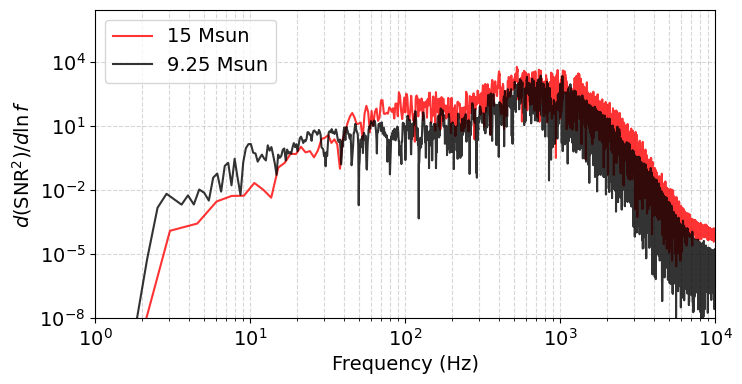

In [9]:
# We can write down a simple function to compute the SNR density
def snr_density(freqs, proj_f, component):
    """Return positive frequencies and d(SNR^2)/dlnf = h_c^2 / S_c^2."""
    mask        = freqs > 0
    f           = freqs[mask]
    h_f         = proj_f[mask]
    h_c         = 2.0 * f * np.abs(h_f)       # characteristic strain
    psd         = component.Sn(f)             # one-sided PSD S_n(f)
    S_c         = np.sqrt(f * psd)            # detector characteristic noise
    density     = (h_c**2) / (S_c**2)         # d(SNR^2)/d ln f
    return f, density

f15, dens15 = snr_density(freqs_15, proj_0_15.T[0], component)
f9,  dens9  = snr_density(freqs_9,  proj_0_9.T[0],  component)

plt.figure(figsize=(8,4))
plt.loglog(f15, dens15, label='15 Msun', color='r', alpha=0.8)
plt.loglog(f9,  dens9,  label='9.25 Msun', color='k', alpha=0.8)
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$d(\mathrm{SNR}^2)/d\ln f$')
plt.legend()
plt.xlim(1, 1e4)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.ylim(bottom=1e-8)   # adjust limits if needed
plt.show()

We see that the signals have high SNR after 100 Hz and at high frequencies (kHz). This will be relevant later when we discuss the long wavelength approximation.

We can also compute the SNR for these signals for our ET configuration at 10 kpc.

In [10]:
component   = detector.components[0]  # 0th component

def compute_snr(freqs, proj_f, component):
    f, integrand    = snr_density(freqs, proj_f, component)
    snr2            = np.trapz(integrand, x=np.log(f))   # integral over ln f
    return np.sqrt(snr2)

# use the projected frequency-domain signals you computed earlier
snr_15 = compute_snr(freqs_15, proj_0_15.T[0], component)
snr_9  = compute_snr(freqs_9,  proj_0_9.T[0], component)

print(f"Estimated SNR (ET, component 0): 15 Msun = {snr_15:.1f} ; 9.25 Msun = {snr_9:.1f}")

Estimated SNR (ET, component 0): 15 Msun = 37.9 ; 9.25 Msun = 19.8


However this is just for a single components, ET has 3 components and we need to combine them to get the full SNR. SNR sums in quadrature across components, or in other words the total SNR is given by
$$
\mathrm{SNR}_{total}^2 = \sum_{i=1}^{N_{components}} \mathrm{SNR}_i^2
$$

In [11]:
snr_15_squared      = 0
snr_9_squared       = 0
for i, comp in enumerate(detector.components):
    projected_15    = proj_0_15.T[i] # get projection for component i
    projected_9     = proj_0_9.T[i]

    snr_15_comp     = compute_snr(freqs_15, projected_15, comp)
    snr_9_comp      = compute_snr(freqs_9,  projected_9,  comp)

    snr_15_squared  += snr_15_comp**2
    snr_9_squared   += snr_9_comp**2

print(f"Total Estimated SNR (ET): 15 Msun = {np.sqrt(snr_15_squared):.1f} ; 9.25 Msun = {np.sqrt(snr_9_squared):.1f}")

Total Estimated SNR (ET): 15 Msun = 64.0 ; 9.25 Msun = 33.7


## High Frequency Behavior and Long Wavelength Approximation

However as we mentioned before the high frequency content of the signal means that the long wavelength approximation may not be valid for ET at these frequencies. This is an approximation that does not hold when the wavelength of the GW is comparable to or smaller than the size of the detector. 

Specifically we need to take it into account when the frequency is higher than 
$$
f_c = \frac{c}{2\pi L}
$$
Afterwards the transfer function of the detector and is decreasing. For ET, which is 10km long this frequency is particulalrly high
$$
f_c^{ET} = \frac{3\times10^5\, \mathrm{km/s}}{(2\pi\times 10 \,\mathrm{km})} \approx 5 \mathrm{kHz}
$$
And therefore including the LWA makes a difference but it is less evident. However for detectors like Cosmic Explorer, which is 40km long, this frequency is lower
$$
f_c^{CE} = \frac{3\times10^5\, \mathrm{km/s}}{(2\pi\times 40 \,\mathrm{km})} \approx 1 \mathrm{kHz}
$$
And therefore including the LWA can make a difference.

We can start by adding Cosmic Explorer to our configuration file. 

In [12]:
det_yaml = Path("detector.yaml")

ce2_block = """\nCE2:
    lat:              46.5 * np.pi / 180.
    lon:              -119.4 * np.pi / 180.
    opening_angle:    np.pi / 2.
    azimuth:          126. * np.pi / 180.
    psd_data:         CE40_psd.txt
    duty_factor:      0.85
    detector_class:   earthL
    plotrange:        10, 1000, 1e-25, 1e-20
    fmin:             8
    fmax:             10000
    spacing:          geometric
    df:               1./4.
    npoints:          10_000
    arm_length:       40_000
"""

# making sure CE2 entry is in detector.yaml
if not det_yaml.exists():
    det_yaml.write_text(ce2_block.lstrip())
    print("Created detector.yaml with CE2 entry")
else:
    txt = det_yaml.read_text()
    if "CE2:" in txt:
        print("CE2 entry already present in detector.yaml — skipping")
    else:
        if not txt.endswith("\n"):
            txt += "\n"
        det_yaml.write_text(txt + ce2_block)
        print("Appended CE2 entry to detector.yaml")

Appended CE2 entry to detector.yaml


Once we have our correctly setup detector configuration we can compute the SNR including enabling or disabling the long wavelength approximation.

/home/ludo/.local/lib/python3.10/site-packages/GWFish/modules/detection.py:457: RuntimeWarning: invalid value encountered in divide
  return np.sin(x)/x


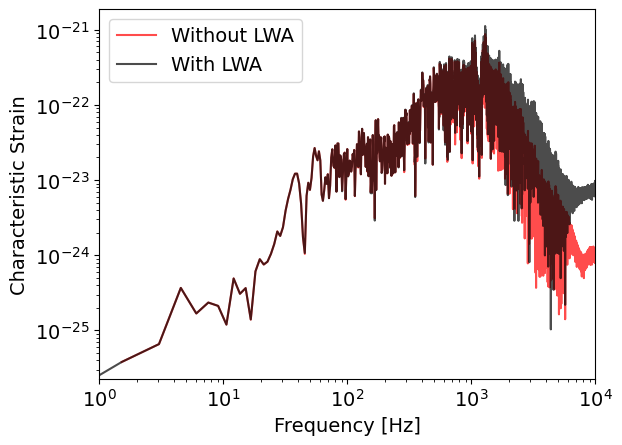

In [13]:
det_no_lwa      = ["CE2"]

projections_15_no_lwa, _ = ll.calculate_detector_projections(
    detector_ids    =   det_no_lwa,
    hp_f            =   hp_f_15,
    hc_f            =   hc_f_15,
    freqs           =   freqs_15,
    sky_params      =   params_tutorial,
    config          =   config,
    lwa_approx      =   False
)

projections_15_lwa, _   = ll.calculate_detector_projections(
    detector_ids    =   det_no_lwa,
    hp_f            =   hp_f_15,
    hc_f            =   hc_f_15,
    freqs           =   freqs_15,
    sky_params      =   params_tutorial,
    config          =   config,
    lwa_approx      =   True
)

plt.loglog(
    freqs_15,
    2  * freqs_15 * np.abs(projections_15_no_lwa.T[0]),
    label="Without LWA",
    color='r',
    alpha=0.7
)

plt.loglog(
    freqs_15,
    2 * freqs_15 * np.abs(projections_15_lwa.T[0]),
    label="With LWA",
    color='k',  
    alpha=0.7
)

plt.ylabel("Characteristic Strain")
plt.xlabel("Frequency [Hz]")
plt.xlim(1, 1e4)
plt.legend()
plt.show()

We can already visually see that including the removing LWA reduces the high frequency content of the projected signal. We can also use the helper functions of the ludolib to compute the SNR quickly without having to redo the full projection ourselves.

In [14]:
snr_15_t = ll.calculate_network(
    freq        = freqs_15,
    hp          = hp_f_15,
    hc          = hc_f_15,
    detectors   = det_no_lwa,
    params      = [params_tutorial],
    config      = config,
    lwa_approx  = True
)[0][2] # This helper function outputs for each set of params, and gives (ra, dec, snr)

snr_15_f = ll.calculate_network(
    freq        = freqs_15,
    hp          = hp_f_15,
    hc          = hc_f_15,
    detectors   = det_no_lwa,
    params      = [params_tutorial],
    config      = config,
    lwa_approx  = False
)[0][2]

print(f"SNR including LWA: {snr_15_t:.2f}")
print(f"SNR without LWA:  {snr_15_f:.2f}")
print(f"SNR overestimation : {snr_15_t/snr_15_f - 1:.2%}")

SNR including LWA: 41.59
SNR without LWA:  38.67
SNR overestimation : 7.56%


## Getting the SNR distribution

What we have currently done is to compute the SNR for a single sky location and polarization angle. However we would like to know the distribution of SNRs across the sky, as well as the horizon distance.

The horizon is relatively simple, as we already scale the signal to a given distance D (10 kpc in this case), we can just compute the SNR at that distance, and then scale it linearly to get the horizon distance. The usual target for SNR is 8.

For the sky localization distribution we can use the ludolib helper function `calculate_network` which will compute the SNR across multiple parameter sets. 
And we can use another helper function `generate_args_list` to randomly generate sky locations and polarization angles. We generate the angles according to uniform distributions on the sphere (see [this](https://gwfish.readthedocs.io/en/latest/tutorials/tutorial_randomization.html) GWFish tutorial for more details).

In [27]:
params_list_of_dicts = ll.generate_args_list(n_points = 300, n_psi = 100, average_psi = True)

We average over psi otherwise we would need to sample many more points to get a good coverage of the polarization angle. And for this tutorial it is fine if the SNR estimate is not perfect.

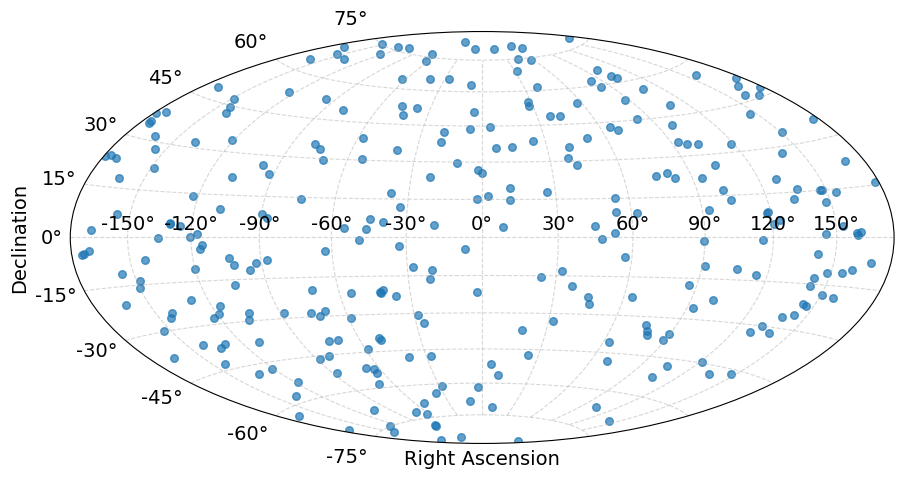

In [28]:
# We can make a plot of the ra/dec distribution to see if it looks reasonable.
params_list_of_dicts

ra_dec = np.array([
    [params["ra"], params["dec"]] for params in params_list_of_dicts
])

ra, dec = ra_dec.T

# Convert to proper longitude for Hammer projection (centered at RA=180°)
lon = ra - np.pi  # shift RA to [-π, π]
lat = dec

# Create Hammer projection plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='hammer')

ax.scatter(lon, lat, alpha=0.7, s=30)
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

We can then input this list of parameters to the `calculate_network` function to get the SNR distribution across the sky.

In [29]:
snr_15_f = ll.calculate_network(
    freq        = freqs_15,
    hp          = hp_f_15,
    hc          = hc_f_15,
    detectors   = det_no_lwa,
    params      = params_list_of_dicts,
    config      = config,
    lwa_approx  = False
)

In [30]:
snr_values_15   = [snr for (_, _, snr) in snr_15_f]

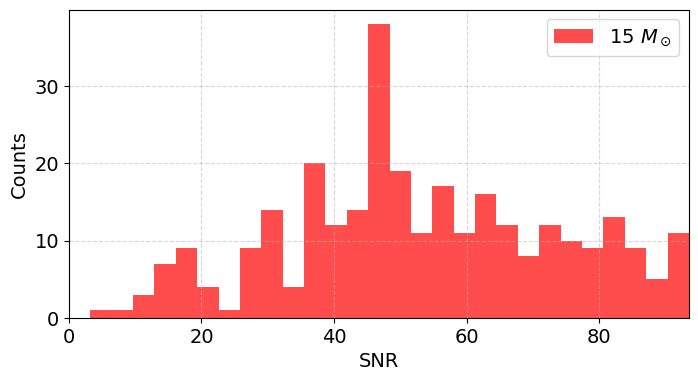

In [31]:
# Plot histogram of SNR values
plt.figure(figsize=(8, 4))
bins = np.linspace(0, max(snr_values_15), 30)
plt.hist(snr_values_15, bins=bins, color='r', alpha=0.7, label='15 $M_\odot$')   
plt.xlabel("SNR")
plt.ylabel("Counts")
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.xlim(0, max(snr_values_15))
plt.show()

We can take the median SNR and see at what distance we would get SNR=8

In [32]:
median_snr_15 = np.median(snr_values_15)
horizon_distance_15 = (median_snr_15 / 8) * 10 # in kpc
print(f"Median SNR for 15 Msun: {median_snr_15:.2f}")
print(f"Horizon distance for 15 Msun (SNR=8): {horizon_distance_15:.2f} kpc")  

Median SNR for 15 Msun: 49.85
Horizon distance for 15 Msun (SNR=8): 62.32 kpc


As an exercise you can try to compute the same for the 9.25 Msun supernova waveform and compare the horizon distances.